In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

In [3]:
df = pd.read_csv('/content/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
df_cluster = df[['Pclass','Sex','Age','SibSp','Parch','Fare']]
df_cluster.dropna(inplace=True)
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  714 non-null    int64  
 1   Sex     714 non-null    object 
 2   Age     714 non-null    float64
 3   SibSp   714 non-null    int64  
 4   Parch   714 non-null    int64  
 5   Fare    714 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 39.0+ KB


<ipython-input-39-3e5a221974b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.dropna(inplace=True)


## Обработка категориальных признаков

In [41]:
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df_cluster[['Pclass', 'Sex']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Pclass', 'Sex']))
encoded_df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0


In [47]:
df_cluster_final = pd.concat([df_cluster.drop(['Pclass', 'Sex'],axis=1).reset_index(),encoded_df],axis=1)
df_cluster_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       714 non-null    int64  
 1   Age         714 non-null    float64
 2   SibSp       714 non-null    int64  
 3   Parch       714 non-null    int64  
 4   Fare        714 non-null    float64
 5   Pclass_1    714 non-null    float64
 6   Pclass_2    714 non-null    float64
 7   Pclass_3    714 non-null    float64
 8   Sex_female  714 non-null    float64
 9   Sex_male    714 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 55.9 KB


## Определение оптимального количества кластеров

Способ 1 - метод локтя

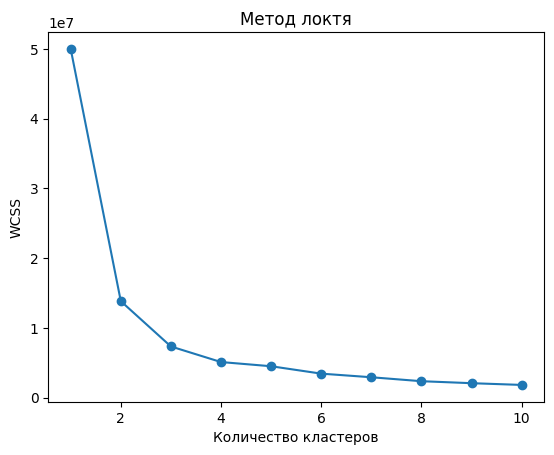

In [49]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_cluster_final)
    wcss.append(kmeans.inertia_)

# Построение графика
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

На графике ищите точку, где кривая начинает выравниваться (локоть). Это и будет оптимальное количество кластеров.

Способ 2 - Силуэтный анализ

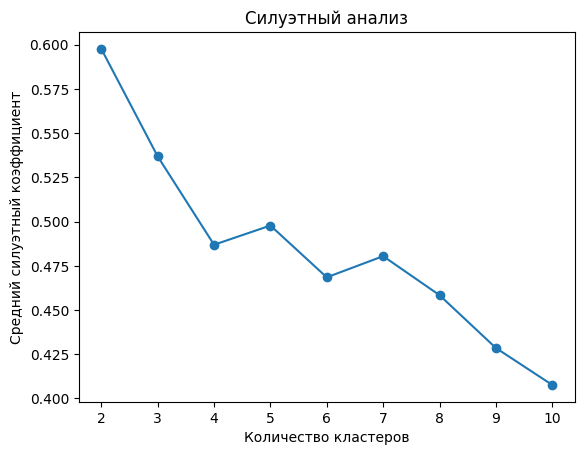

In [51]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_cluster_final)
    score = silhouette_score(df_cluster_final, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Силуэтный анализ')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний силуэтный коэффициент')
plt.show()

Выберите количество кластеров, при котором средний силуэтный коэффициент максимален.

Берем за количество кластеров = 2

## Алгоритмы кластеризации

In [54]:
param_grid = {
    'n_clusters': range(2, 11),  # Количество кластеров
    'init': ['k-means++', 'random'],  # Метод инициализации центроидов
    'max_iter': [100, 200, 300],  # Максимальное количество итераций
}

kmeans = KMeans()

grid_search = GridSearchCV(
    estimator=kmeans,
    param_grid=param_grid,
    scoring=lambda estimator, X: silhouette_score(X, estimator.fit(X).labels_),
    cv=5
)

grid_search.fit(df_cluster_final)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший силуэтный коэффициент:", grid_search.best_score_)

Лучшие параметры: {'init': 'random', 'max_iter': 300, 'n_clusters': 2}
Лучший силуэтный коэффициент: 0.5190140930968457


In [69]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_cluster_final)
labels_kmeans = kmeans.labels_

# Оценка качества
silhouette = silhouette_score(df_cluster_final, labels_kmeans)
calinski_harabasz = calinski_harabasz_score(df_cluster_final, labels_kmeans)
davies_bouldin = davies_bouldin_score(df_cluster_final, labels_kmeans)

print(f"Силуэтный коэффициент: {silhouette}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz}")
print(f"Индекс Дэвиса-Болдина: {davies_bouldin}")

Силуэтный коэффициент: 0.5976336322295904
Индекс Калински-Харабаса: 1862.2661081995905
Индекс Дэвиса-Болдина: 0.543512412571266


DBSCAN

DBSCAN имеет два ключевых гиперпараметра:

* eps (максимальное расстояние между соседями)

* min_samples (минимальное количество точек для формирования кластера)

In [63]:
import warnings
warnings.filterwarnings("ignore")

param_grid = {
    'eps': range(10, 300, 30),
    'min_samples': range(10, 300, 30),
}

db = DBSCAN()

grid_search = GridSearchCV(
    estimator=db,
    param_grid=param_grid,
    scoring=lambda estimator, X: silhouette_score(X, estimator.fit(X).labels_),
    cv=5
)

grid_search.fit(df_cluster_final)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший силуэтный коэффициент:", grid_search.best_score_)

Лучшие параметры: {'eps': 130, 'min_samples': 10}
Лучший силуэтный коэффициент: 0.7441701982608212


In [70]:
db = DBSCAN(eps=130, min_samples=10)
db.fit(df_cluster_final)
labels_db = db.labels_

# Оценка качества
silhouette = silhouette_score(df_cluster_final, labels_db)
calinski_harabasz = calinski_harabasz_score(df_cluster_final, labels_db)
davies_bouldin = davies_bouldin_score(df_cluster_final, labels_db)

print(f"Силуэтный коэффициент: {silhouette}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz}")
print(f"Индекс Дэвиса-Болдина: {davies_bouldin}")

Силуэтный коэффициент: 0.40398502624212385
Индекс Калински-Харабаса: 12.230688911310752
Индекс Дэвиса-Болдина: 1.3993655575357655


In [71]:
set(labels_db)

{-1, 0}

In [72]:
set(labels_kmeans)

{0, 1}

## Визуализация результата кластеризации

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #рса на два компонента
pca.fit(df_cluster_final) #обучаем
reduced = pca.transform(df_cluster_final)
pca_df=pd.DataFrame(reduced)
pca_df.columns=['x','y']

In [75]:
fig = px.scatter(pca_df, x="x", y="y")
fig.update_traces(marker_size=20)
fig.show()

In [76]:
fig = px.scatter(pca_df, x="x", y="y", color=labels_kmeans)
fig.update_traces(marker_size=20)
fig.show()

In [77]:
fig = px.scatter(pca_df, x="x", y="y", color=labels_db)
fig.update_traces(marker_size=20)
fig.show()

In [78]:
fig = px.scatter(df_cluster_final, x="Fare", y="Age", color=labels_kmeans)
fig.update_traces(marker_size=20)
fig.show()

## Профилирование кластеров (объяснение)

In [80]:
df_cluster_final['cluster']=labels_kmeans

In [82]:
pd.set_option('display.max_rows', 80) # для удосбтва анализа делаем
df_cluster_final.groupby('cluster', observed=True).agg(['count','mean', 'std']).T

cluster                    0           1
index      count  363.000000  351.000000
           mean   226.212121  676.521368
           std    130.089224  126.049691
Age        count  363.000000  351.000000
           mean    28.583333   30.853048
           std     14.124448   14.863024
SibSp      count  363.000000  351.000000
           mean     0.561983    0.461538
           std      0.990780    0.860616
Parch      count  363.000000  351.000000
           mean     0.451791    0.410256
           std      0.847333    0.860105
Fare       count  363.000000  351.000000
           mean    34.992091   34.386764
           std     52.806063   53.109033
Pclass_1   count  363.000000  351.000000
           mean     0.236915    0.284900
           std      0.425776    0.452011
Pclass_2   count  363.000000  351.000000
           mean     0.256198    0.227920
           std      0.437135    0.420090
Pclass_3   count  363.000000  351.000000
           mean     0.506887    0.487179
           std      0.500643    0.500549
Sex_female count  363.000000  351.000000
           mean     0.382920    0.347578
           std      0.486770    0.476881
Sex_male   count  363.000000  351.000000
           mean     0.617080    0.652422
           std      0.486770    0.476881

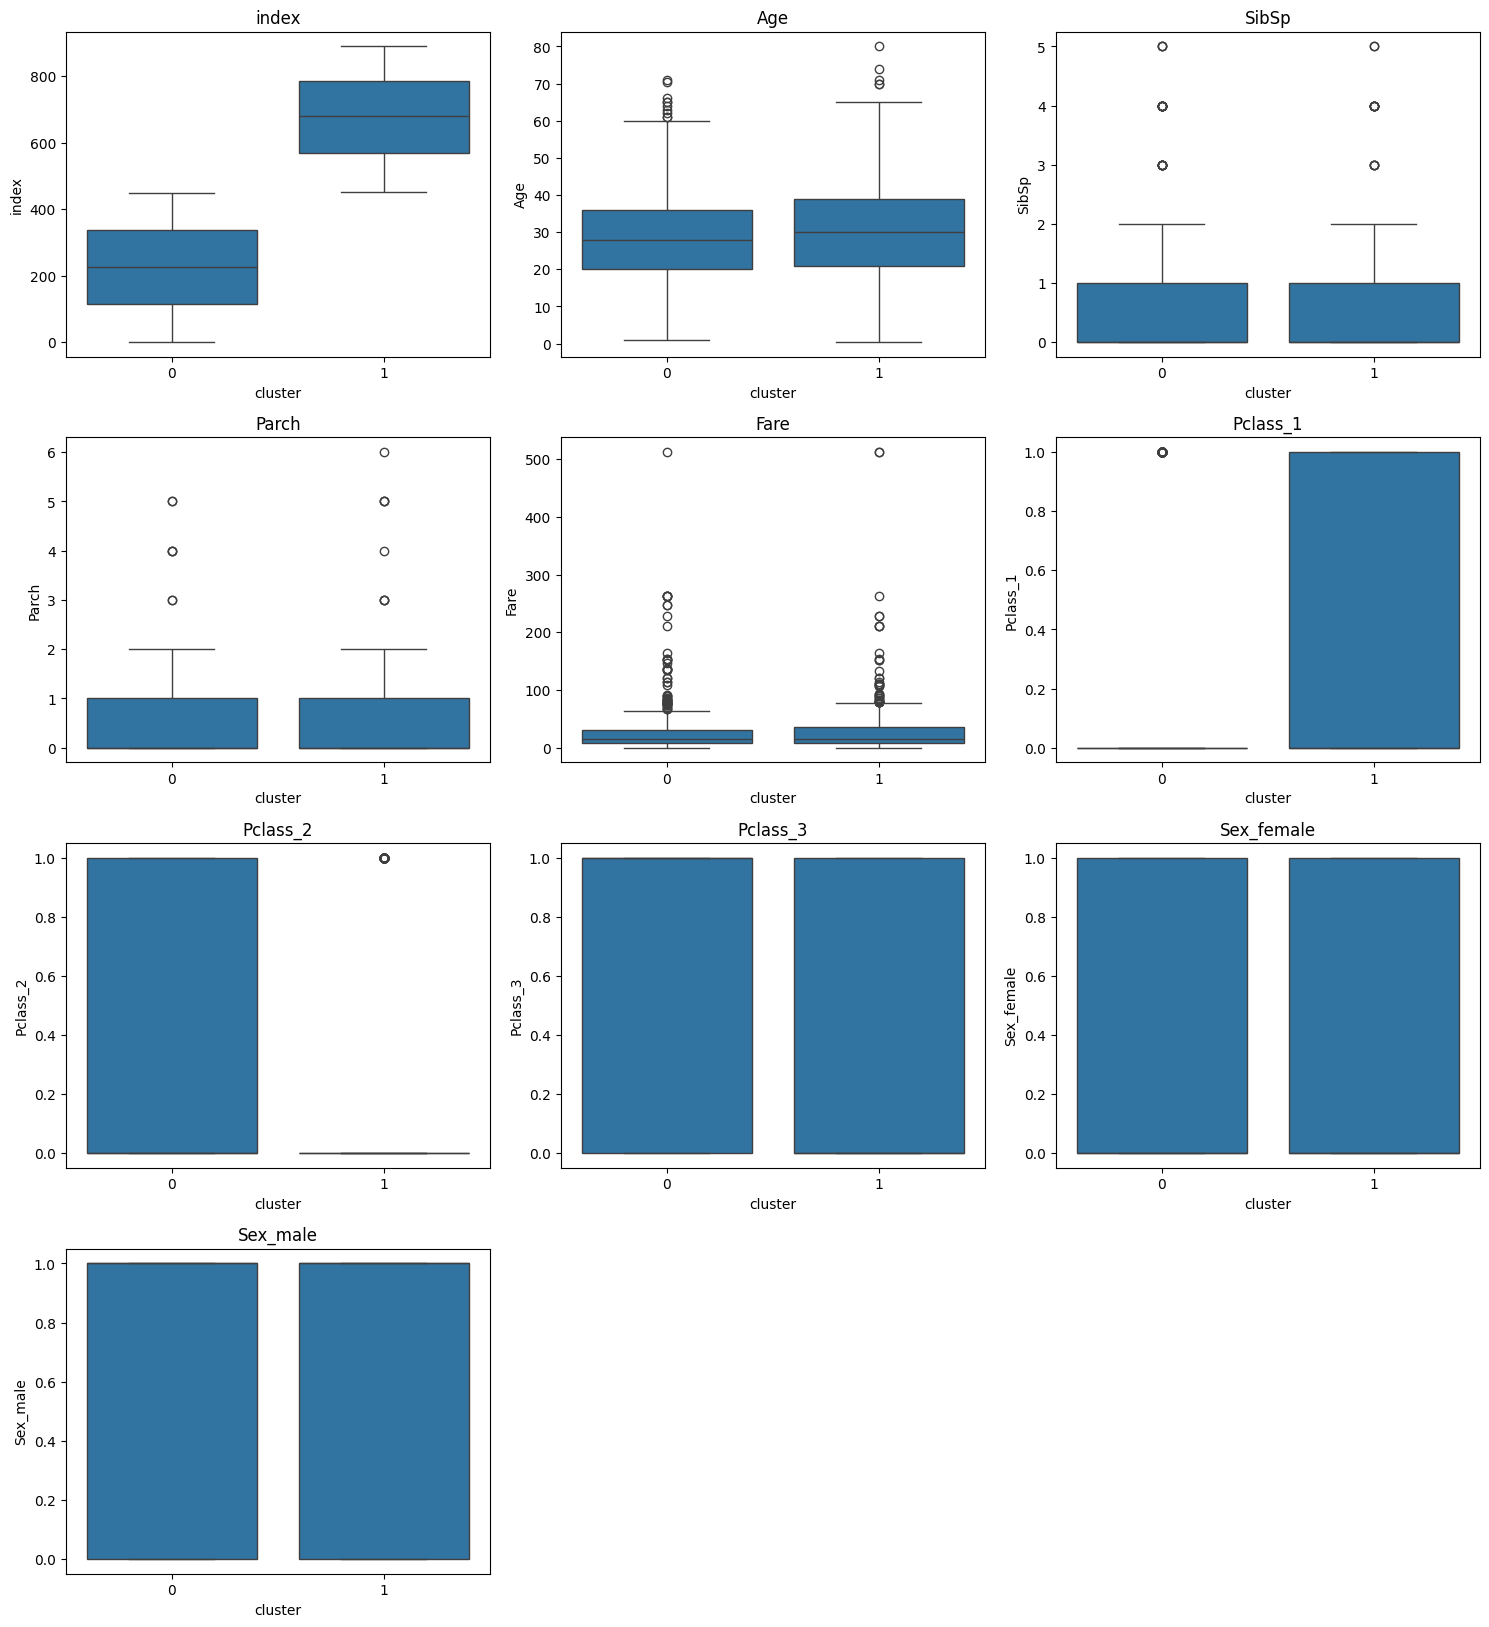

In [88]:
plt.figure(figsize=(15, 20))

for i, column in enumerate(df_cluster_final.columns[:-1], 1):
    plt.subplot(5, 3, i)  # Установка 5 строк и 3 столбцов для графиков
    sns.boxplot(data=df_cluster_final, x='cluster', y=column)
    plt.title(f'{column}')

plt.tight_layout()
plt.show()